# Import

In [1]:
import os
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import print_function, division
from random import randrange

from keras.preprocessing import image
from keras.datasets import fashion_mnist, cifar10, mnist
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate, MaxPooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, UpSampling2D, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
import keras.backend as K

Using TensorFlow backend.


<h1 style="text-align: center;"> EMNIST </h1>

# Preprocessing

In [84]:
# Import data 
# Note that both the uppercase and lowercase variants of a single letter belong to the same class
data = pd.read_csv("data/emnist-letters.csv")
ys_real = data.iloc[:,0].values - 1
Xs_real = data.iloc[:,1:].values

# Some constants and parameters
N_SAMPLES = data.shape[0]
N_CLASSES = len(np.unique(ys_real))
IMAGE_SIZE = 28

# Normalize pixels' values between -1 and 1, and reshape the images
Xs_real = -1 + 2 * (Xs_real / np.max(Xs_real))
Xs_real = Xs_real.reshape(N_SAMPLES, IMAGE_SIZE, IMAGE_SIZE)
for i in range(N_SAMPLES):
    Xs_real[i] = Xs_real[i].T
Xs_real = Xs_real.reshape(N_SAMPLES, IMAGE_SIZE, IMAGE_SIZE, 1)
    
# Create a map from labels to their corresponding English letters
letters = [chr(i) for i in range(65, 91)]
letters_map = {index: letter for (index, letter) in enumerate(letters)}
print(letters_map)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [62]:
# Sort the data such that images for the same letters are consecutive in order
# This might improve the results of the training a bit
sorted_order = np.argsort(ys_real)
ys_real = ys_real[sorted_order]
Xs_real = Xs_real[sorted_order]

Sample 41644, Letter F


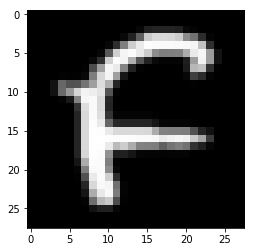

In [85]:
# Pick a random image from the data and show 
index = randrange(N_SAMPLES)
image = Xs_real[index].reshape(IMAGE_SIZE, IMAGE_SIZE)
letter = letters_map[ys_real[index]]
print("Sample %d, Letter %s" % (index, letter))
plt.imshow(image, cmap="gray")
plt.show()

# Models

In [86]:
Z_DIMENSION = 100
y_input = Input(shape=(N_CLASSES,))
Z_input = Input(shape=(Z_DIMENSION,))
X_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

In [94]:
def get_generator(Z_input, y_input):
    """
    @param Z_dim: input tensor for the noise vector Z.
    @param y_dim: input tensor for the conditional vector y, with dimensionality equal to number of classes
                  (since y is the one-hot-encoded vector representing which class we want to generate).
    """
    concatenated_input = Concatenate()([Z_input, y_input])
#     layer = Dense(1024)(concatenated_input)
#     layer = BatchNormalization()(layer)
#     layer = Activation("relu")(layer)
    
#     layer = Dense(256)(layer)
#     layer = BatchNormalization()(layer)
#     layer = Activation("relu")(layer)
    
    layer = Dense(128*7*7)(concatenated_input)
    layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    layer = Reshape((7,7,128))(layer)
    
    layer = UpSampling2D(size=2)(layer)
    layer = Conv2DTranspose(64, kernel_size=3, strides=1, padding="same")(layer)
    layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    
    layer = Conv2DTranspose(32, kernel_size=3, strides=1, padding="same")(layer)
    layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    
    layer = Conv2DTranspose(16, kernel_size=3, strides=1, padding="same")(layer)
    layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    
    layer = UpSampling2D(size=2)(layer)
    layer = Conv2DTranspose(1, kernel_size=3, strides=1, padding="same")(layer)
    layer = Activation("tanh")(layer)
    model = Model(inputs=[Z_input, y_input], outputs=layer)
    return model

G = get_generator(Z_input, y_input)
G.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 26)           0                                            
__________________________________________________________________________________________________
concatenate_22 (Concatenate)    (None, 126)          0           input_11[0][0]                   
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 6272)         796544      concatenate_22[0][0]             
__________

In [96]:
def get_discriminator(X_input, y_input):
    """
    @param X_input: input tensor for the actual image X.
    @param y_input: input tensor for the conditional vector y, with dimensionality equal to number of classes
                    (since y is the one-hot-encoded vector representing which class we want to generate).
    """
    layer = Conv2D(32, kernel_size=3, strides=2, padding="same")(X_input)
    layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    
    layer = Conv2D(64, kernel_size=5, strides=2, padding="same")(X_input)
    layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    
    layer = Conv2D(128, kernel_size=5, strides=2, padding="same")(X_input)
    layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    
    layer = Flatten()(layer)
    layer = Concatenate()([layer, y_input])
    
    
    layer = Dense(256)(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.4)(layer)
    layer = Activation("relu")(layer)
    
    layer = Dense(128)(layer)
#     layer = BatchNormalization()(layer)
#     layer = Dropout(0.4)(layer)
#     layer = Activation("relu")(layer)
    layer = Dropout(0.25)(layer)
    layer = Dense(1)(layer)
    layer = Activation("sigmoid")(layer)
    model = Model(inputs=[X_input, y_input], outputs=layer)
    return model

opt = Adam( 0.002, 0.5 )
D = get_discriminator(X_input, y_input)
D.compile(loss="binary_crossentropy", optimizer=opt)
D.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 14, 14, 128)  3328        input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, 14, 14, 128)  512         conv2d_29[0][0]                  
__________________________________________________________________________________________________
activation_109 (Activation)     (None, 14, 14, 128)  0           batch_normalization_87[0][0]     
__________________________________________________________________________________________________
flatten_12

In [97]:
def get_cgan():
    D.trainable = False # freeze discriminator so that only generator is trained
    X_tensor = G([Z_input, y_input])
    output = D([X_tensor, y_input])
    model = Model(inputs=[Z_input, y_input], outputs=output)
    return model

opt = Adam(0.002, 0.5)
cgan = get_cgan()
cgan.compile(loss="binary_crossentropy", optimizer=opt)
cgan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 26)           0                                            
__________________________________________________________________________________________________
model_30 (Model)                (None, 28, 28, 1)    919105      input_11[0][0]                   
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
model_32 (Model)                (None, 1)            6467329     model_30[1][0]                   
          

# Utililities

In [98]:
N_ROWS = 5
N_COLS = 10
N_EPOCHS = 20
BATCH_SIZE = 64
N_BATCHES = math.ceil(N_SAMPLES/BATCH_SIZE)
IMAGES_PATH = "images/"
MODELS_PATH = "models/"
if not os.path.exists(IMAGES_PATH): os.mkdir(IMAGES_PATH)
if not os.path.exists(MODELS_PATH): os.mkdir(MODELS_PATH)

In [91]:
def onehot_encoding(ys):
    onehot = [to_categorical(y, N_CLASSES) for y in ys]
    return np.array(onehot)

def generate_random_Z_noise(numSamples):
    return np.random.normal(0.0, 1.0, size=(numSamples, Z_DIMENSION))

def generate_random_conditions(numSamples):
    return np.random.choice(N_CLASSES, numSamples)

def generate_labels(image_type, flipped_ratio):
    if image_type == "real":
        labels = np.random.uniform(0.9, 1.0, size=(BATCH_SIZE, 1))
    elif image_type == "fake":
        labels = np.random.uniform(0.0, 0.1, size=(BATCH_SIZE, 1))
    flipped_indices = np.random.choice(BATCH_SIZE, size=int(flipped_ratio*BATCH_SIZE))
    labels[flipped_indices] = 1 - labels[flipped_indices]
    return labels

def show_images(epoch, images, conditions):
    targets = [letters_map[c] for c in conditions]
    fig = plt.figure(figsize=(10, 5))
    plt.subplots_adjust(bottom=0, top=1)
    
    for index in range(N_ROWS*N_COLS):
        plt.subplot(N_ROWS, N_COLS, index+1)
        image = images[index].reshape(IMAGE_SIZE, IMAGE_SIZE)
        plt.imshow(image, cmap="gray")
        plt.title(targets[index])
        plt.axis("off")
    plt.savefig(IMAGES_PATH + "epoch" + str(epoch) + ".png")
    plt.show()

def show_progress(epoch):
    numSamples = N_ROWS*N_COLS
    Z_noise = generate_random_Z_noise(numSamples)
    conditions = generate_random_conditions(numSamples)
    onehot_conditions = onehot_encoding(conditions)
    images = G.predict([Z_noise, onehot_conditions])
    show_images(epoch, images, conditions)
    
def save_progress(epoch):
    G.save(MODELS_PATH + "G_epoch" + str(epoch) + ".h5")
    D.save(MODELS_PATH + "D_epoch" + str(epoch) + ".h5")
    

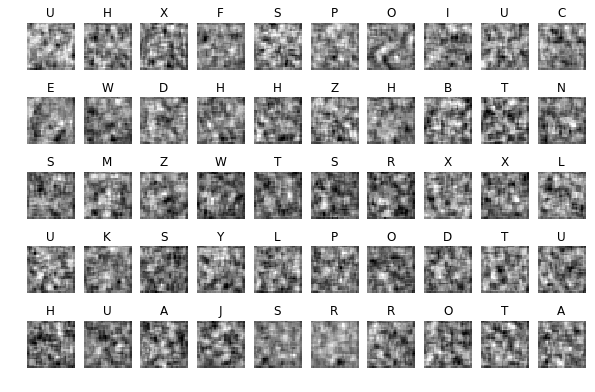

In [21]:
G = get_generator(Z_input,y_input)
show_progress(22)

# Training and Evaluation

In [15]:
X = [i+1 for i in range(50)]
X = np.array(X)
print(X[-5:])

[46 47 48 49 50]


In [18]:
D.metrics_names

['loss', 'acc']

/home/student/anaconda3/envs/dml_gpu/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0, G-Loss: 1.1169291444187206, D-Loss: 0.5787641445137238


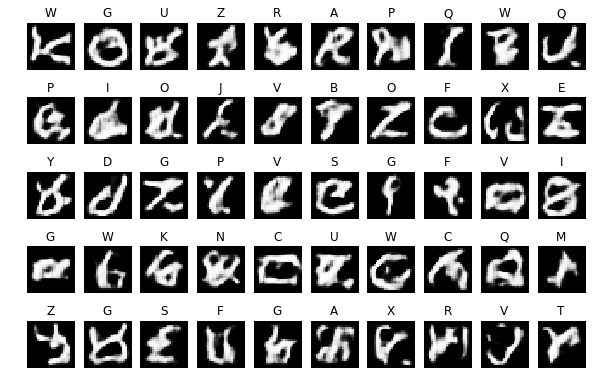

Epoch: 1, G-Loss: 1.566363105126348, D-Loss: 0.4641491321347632


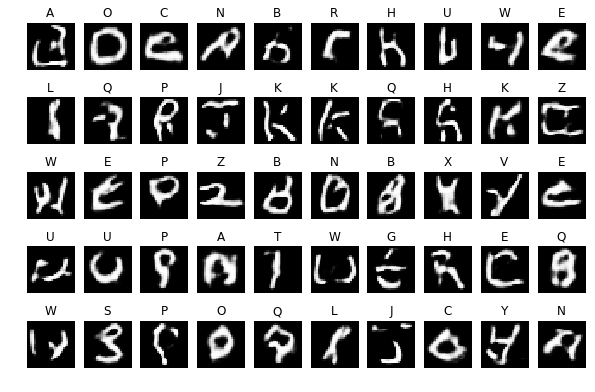

Epoch: 2, G-Loss: 1.338721601179766, D-Loss: 0.49250829509682204


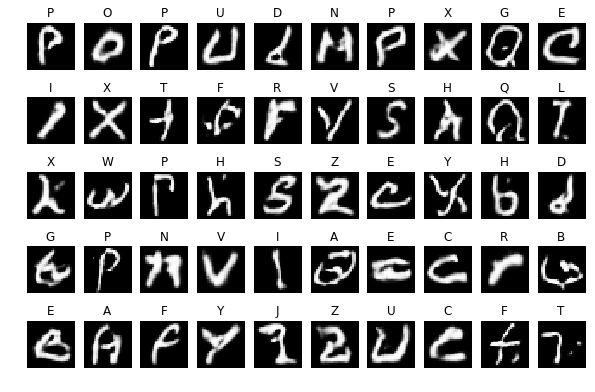

Epoch: 3, G-Loss: 1.5114760967427785, D-Loss: 0.48043059340815036


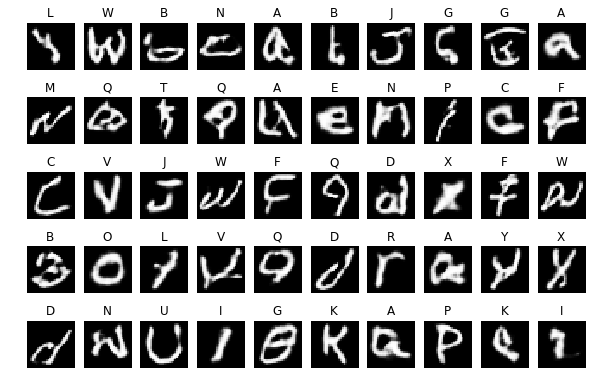

Epoch: 4, G-Loss: 1.5970497017119736, D-Loss: 0.46929858865414986


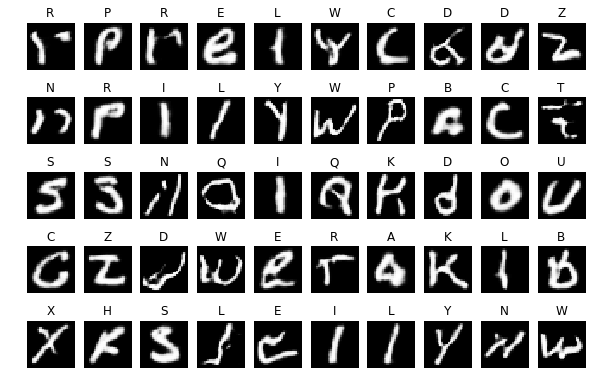

Epoch: 5, G-Loss: 1.6745094962697207, D-Loss: 0.4570150436989169


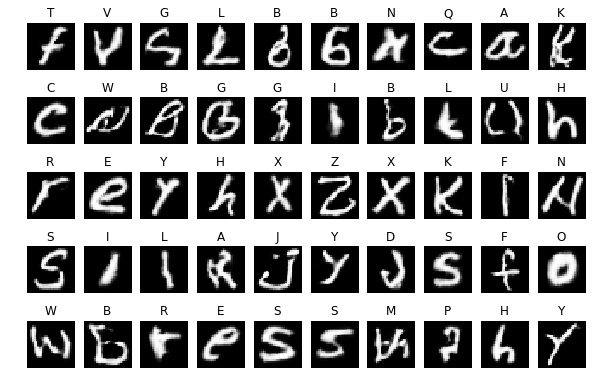

Epoch: 6, G-Loss: 1.7520058065738733, D-Loss: 0.44301024126559924


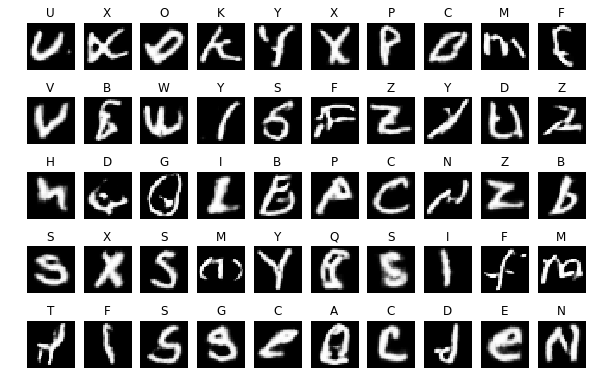

Epoch: 7, G-Loss: 1.8210906168225862, D-Loss: 0.4331631350843638


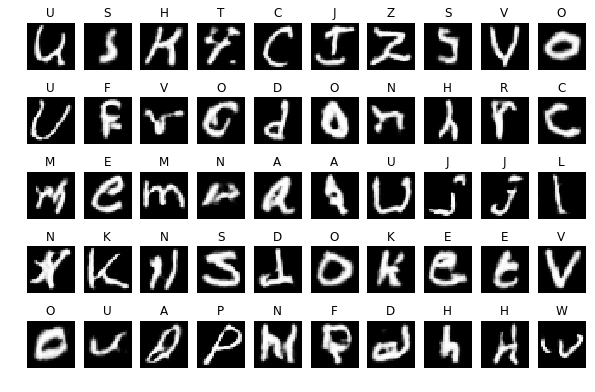

Epoch: 8, G-Loss: 1.8607229489070882, D-Loss: 0.42218819891856796


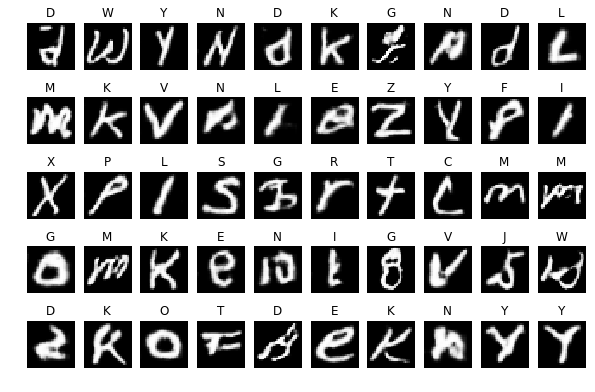

Epoch: 9, G-Loss: 1.9116909279775207, D-Loss: 0.4167310707163742


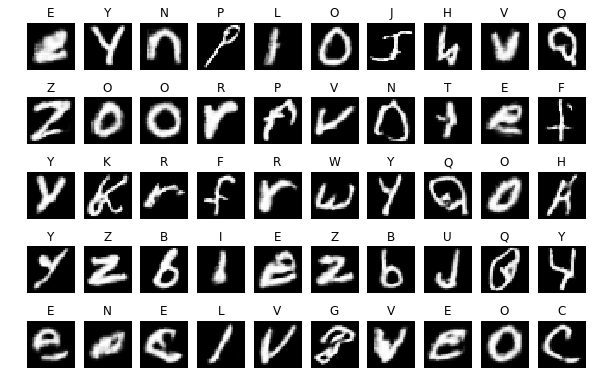

Epoch: 10, G-Loss: 1.9585869123337936, D-Loss: 0.4097674500615865


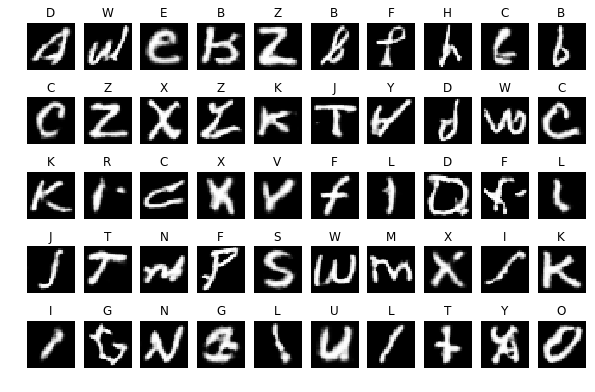

Epoch: 11, G-Loss: 1.9921380950497618, D-Loss: 0.4061028325677949


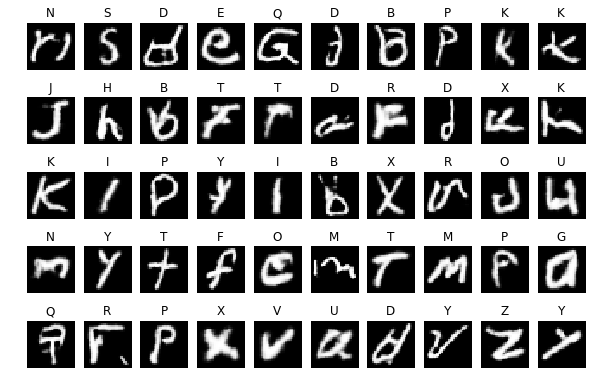

Epoch: 12, G-Loss: 2.0291955337057197, D-Loss: 0.39728813867489954


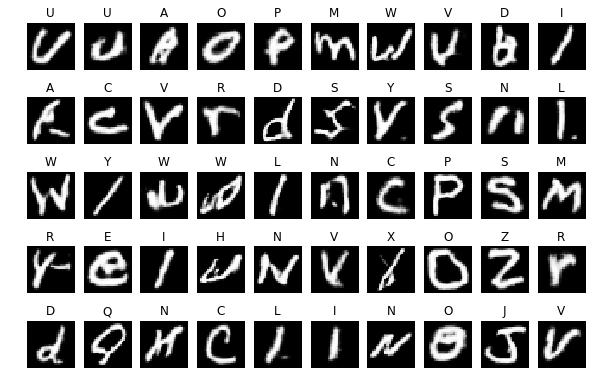

Epoch: 13, G-Loss: 2.0398732829162642, D-Loss: 0.3967414424252785


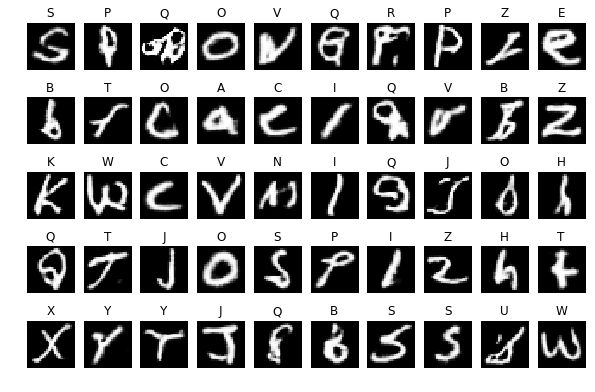

Epoch: 14, G-Loss: 2.071093133873486, D-Loss: 0.3910503248960553


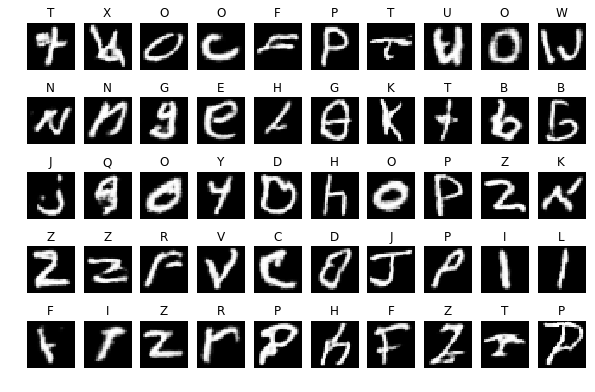

Epoch: 15, G-Loss: 2.0928371723859387, D-Loss: 0.3908457999313599


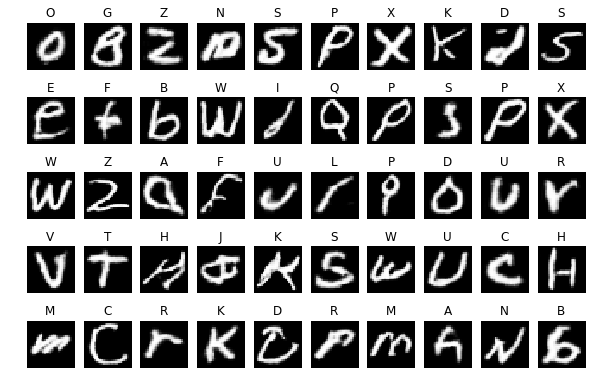

Epoch: 16, G-Loss: 2.114422664948087, D-Loss: 0.3820674963918131


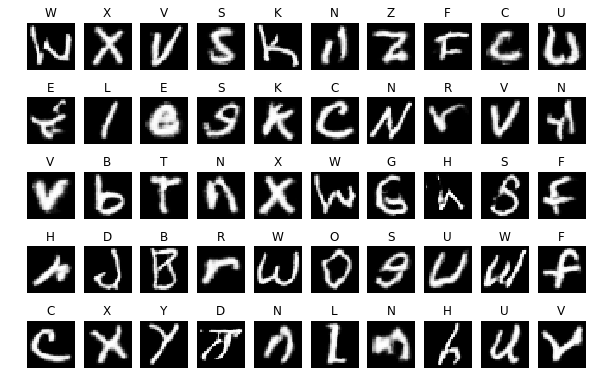

Epoch: 17, G-Loss: 2.1250949949455538, D-Loss: 0.381411584378663


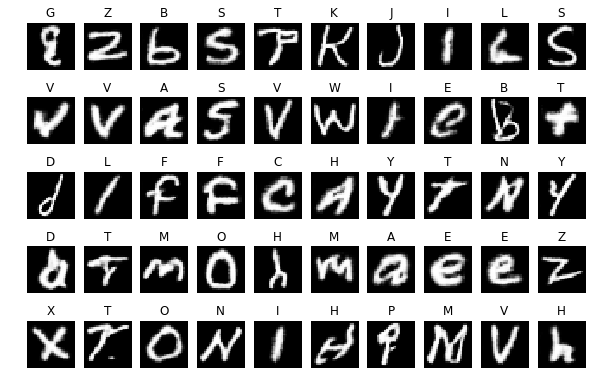

Epoch: 18, G-Loss: 2.1496095945065576, D-Loss: 0.379141140654039


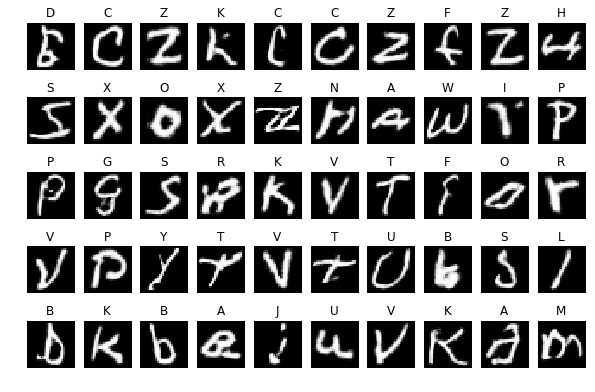

Epoch: 19, G-Loss: 2.1886005442836445, D-Loss: 0.37171737516905456


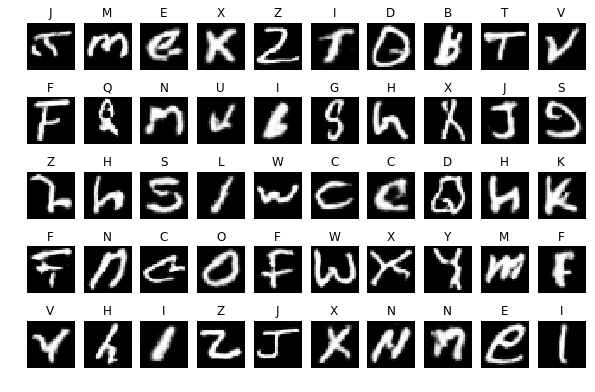

In [99]:
for epoch in range(N_EPOCHS):
    D_total_loss = 0
    G_total_loss = 0

    for batch in range(N_BATCHES):        
        # get real data
        if batch == N_BATCHES-1:
            X_real = Xs_real[-BATCH_SIZE:] # images
            y_real = ys_real[-BATCH_SIZE:] # conditions
        else:
            X_real = Xs_real[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE] # images
            y_real = ys_real[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE] # conditions
        y_real = onehot_encoding(y_real)
        
        # generate fake data using the same conditional vectors
        Z_fake = generate_random_Z_noise(BATCH_SIZE)
        y_fake = y_real
        X_fake = G.predict([Z_fake, y_fake])
        
        # train discriminator on real data
        soft_labels_real = generate_labels("real", 0)
        D_loss_real = D.train_on_batch([X_real, y_real], soft_labels_real)
        
        # train discriminator on fake data
        soft_labels_fake = generate_labels("fake", 0)
        D_loss_fake = D.train_on_batch([X_fake, y_fake], soft_labels_fake)
        
        # train generator with hard labels for real data
        Z_fake = generate_random_Z_noise(BATCH_SIZE)
        hard_labels_real = generate_labels("real", 0)
        G_loss = cgan.train_on_batch([Z_fake, y_fake], hard_labels_real)
        
        # handle the loss
        D_total_loss += np.add(D_loss_real, D_loss_fake) / 2
        G_total_loss += np.array(G_loss)
    
    G_total_loss /= N_BATCHES
    D_total_loss /= N_BATCHES
    print("Epoch: {}, G-Loss: {}, D-Loss: {}"
          .format(epoch, G_total_loss, D_total_loss))
    show_progress(epoch)
    save_progress(epoch)